Import libraries and data


In [1]:
# It connects to the repository to obtain the necessary data to be used throughout the execution of this google colab document.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy import stats
from sklearn.linear_model import LinearRegression

In [3]:
#Library for visualization of data on candlestick charts
!pip install mpl_finance
import mpl_finance as mpf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Extra functions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


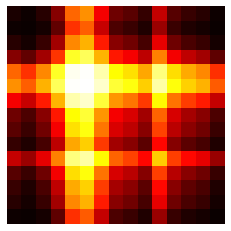

In [6]:
# function to view candlestick chart of labeled pattern
def pattern_show_image(signal, target):           
  fontsize=12
  plt.rcParams['xtick.labelsize'] = fontsize  
  plt.rcParams['ytick.labelsize'] = fontsize 
  plt.rcParams['axes.titlesize'] = fontsize           
  fig = plt.figure(figsize=(8, 8))
  ax = plt.subplot2grid((1, 1), (0, 0))           
  ax.set_xticks(range(10))
  ax.set_xticklabels(target.index)                     
  arr = np.c_[range(target.shape[0]), target[['open', 'max', 'min', 'close']].values]
  mpf.candlestick_ohlc(ax, arr, width=0.5, alpha=1, colordown='#ff1717', colorup='#53c156')          
  locs, labels = plt.xticks() 
  plt.setp(labels , rotation = 45)
  plt.grid()
  ax.legend(loc = 'best', prop = {'size': fontsize})
  title_name = signal
  ax.set_title(title_name)
  fig.subplots_adjust(bottom = 0.25)       
  name = signal
  plt.axis('off')
  plt.show()




# method that prints one image on the screen using GAF
def image_gaf(serie):
    max = np.amax(serie)
    min = np.amin(serie)
    result = serie_tiempo_gaf(serie,max,min)
    plt.imshow(result, cmap='hot', interpolation='nearest')
    plt.axis('off')
    plt.show()


# test, see image of gaf - opening values of japanese candlesticks in a double top pattern
#serie = np.array(['1.44697','1.44678','1.4471','1.44761','1.44802','1.44803','1.4479','1.44752','1.44742','1.44721','1.4478','1.44741','1.44722','1.4471','1.44677']).astype(np.float)

#image_gaf(serie)


Obtain Japanese candlestick information, convert them to images using GAF


In [5]:
# GAF function, converts a time series to a Gramian matrix.
def serie_tiempo_gaf(serie,valueMax,valueMin):
  if valueMax == valueMin:
      mGaf = np.zeros((len(serie), len(serie)))
  else:
      serieNorm = np.array((serie-valueMin) / (valueMax-valueMin))
      serieNormArc = np.arccos(serieNorm)
      mGaf = np.zeros((len(serieNorm), len(serieNorm)))
      for f in range(len(serieNorm)):
          for c in range(len(serieNorm)):
              mGaf[f, c] = np.cos(serieNormArc[f] + serieNormArc[c])
  return mGaf


# Function that receives a set of patterns with a predefined structure and that are converted through the GAF method.
def create_gaf(serie_pattern):
  data = serie_pattern.copy()
  gaf = np.zeros((data.shape[0], data.shape[1], data.shape[1], data.shape[2]))
  for i in range(data.shape[0]):
      for c in range(data.shape[2]):
          oneCat = data[i, :, c]
          maxV = np.amax(oneCat)
          minV = np.amin(oneCat)
          result = serie_tiempo_gaf(oneCat, maxV, minV)
          gaf[i, :, :, c] = result
  return gaf


# Function that returns a structured data series with the candlestick data for each pattern.
# Given from the data of all the patterns recorded.
def create_serie(df_pattern):
  total = int(df_pattern.shape[0] / window )
  serie = np.zeros((total, window, 4)) 
  for N in range(total):
    df = df_pattern.loc[(df_pattern.index >= (N*window)) & (df_pattern.index < (N*window + window))]
    serie[N, :, 0] = df['open']
    serie[N, :, 1] = df['max']
    serie[N, :, 2] = df['min']
    serie[N, :, 3] = df['close']
  return serie
 



Red CNN


In [7]:
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

# Class to instantiate a CNN model
class modelCNN(object):

    # Sets the instance variables
    def __init__(self, data_x, data_y):     
        self.model = None
        self.input_shape = None
        self.label_shape = None
        self.train_history = None
        self.data_x, self.data_y = data_x, data_y 
        self.X_train, self.y_train, self.X_test, self.y_test = None, None, None, None
        self. y_categoricalTrain, self.y_categoricalTest = None, None 

    # Divides the data into a test set and a test set     
    def process(self):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split (self.data_x, self.data_y, test_size= 0.3, random_state = 42)
        self. y_categoricalTrain, self.y_categoricalTest = np_utils.to_categorical(self.y_train), np_utils.to_categorical(self.y_test)
        self.input_shape = self.X_train[0].shape
        self.label_shape = self. y_categoricalTrain.shape[1]
    
    # Set the layers and their characteristics that make up the CNN model
    def build(self):
        self.model = Sequential()
        self.model.add(Conv2D(filters=32, kernel_size=(2, 2), padding='same', input_shape = self.input_shape, activation='relu')) 
        self.model.add(MaxPooling2D(pool_size=(2, 2)))               
        self.model.add(Conv2D(filters=32, kernel_size=(2, 2), padding='same', activation='relu'))
        self.model.add(MaxPooling2D(pool_size=(2, 2)))   
        self.model.add(Dropout(0.25))                                                                                
        self.model.add(Flatten())
        self.model.add(Dense(128, activation='relu'))                                               
        self.model.add(Dropout(0.5))
        self.model.add(Dense(self.label_shape, activation='softmax'))                                            
        print(self.model.summary())                                                                               

    # Training of the model created with the processed data
    def train(self, split):
        self.model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 
        self.train_history = self.model.fit(x = self.X_train, y = self.y_categoricalTrain, validation_split = split, shuffle=True, epochs = 50, batch_size = 50, verbose = 2)      
  
    # Prediction for a specific value with the trained model
    def predictTest(self,dataX):
        prediction = self.model.predict(dataX)
        print(prediction)
        #print(pd.crosstab(self.y_test, prediction, rownames=['label'], colnames=['predict']))
               
    # Save the created/trained model
    def save(self, filename):
        self.model.save(filename)

    # Displays training history
    def show_train_history(self, train_history, train, validation):
        plt.figure()
        plt.plot(train_history.history[train])
        plt.plot(train_history.history[validation])
        plt.title('Train History')
        plt.ylabel(train)
        plt.xlabel('Epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.show()
        
    # Prints out the accuracy values after the delivery it has had
    def show(self):
        self.show_train_history(self.train_history, 'loss', 'val_loss')
        self.show_train_history(self.train_history, 'accuracy', 'val_accuracy')
        score = self.model.evaluate(self.X_test, self.y_categoricalTest)
        print('Score of the Testing Data: {}'.format(score))
        






Processing of the data using GAF and training of a CNN pattern identification model

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 32)        544       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 32)        4128      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 7, 7, 32)          0         
                                                                 
 flatten_2 (Flatten)         (None, 1568)             

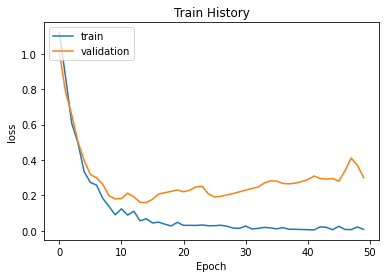

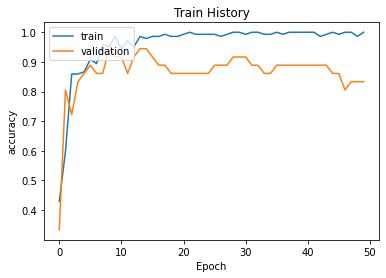

3/3 [==============================] - 0s 8ms/step - loss: 0.2919 - accuracy: 0.9610
Score of the Testing Data: [0.29187196493148804, 0.9610389471054077]


In [10]:
# Function that creates a CNN model and trains it with the labeled data, at the end it displays the training results.
def cnn(dataDic):
  x_data = dataDic['data']
  y_target = dataDic['target']
  model = modelCNN(x_data, y_target) 
  model.process()
  model.build()
  model.train(0.2)
  model.show()

  # Save model
  name = 'model_pattern'
  load_model = 'CNN_' + name + '.h5'
  model.save(load_model)

# Function that structures the data sets for use in the neural network.
# For each set, it is labeled differently from another one
def process_data(d1,d2,d3):
  total = d1.shape[0] + d2.shape[0] + d3.shape[0]
  xSerie = np.zeros((total, window, window, 4))
  xSerie[0:d1.shape[0] - 1, :, :, :] = d1[0:d1.shape[0] - 1, :, :, :] 
  xSerie[d1.shape[0]: d1.shape[0] + d2.shape[0] - 1, :, :, :] = d2[0:d2.shape[0] - 1, :, :, :] 
  xSerie[d1.shape[0] + d2.shape[0]:total -1 , :, :, :] = d3[0:d3.shape[0] - 1, :, :, :] 
  yData = []
  ls = [0] * d1.shape[0] 
  yData.extend(ls)
  ls = [1] * d2.shape[0]
  yData.extend(ls)
  ls = [2] * d3.shape[0]
  yData.extend(ls)
  ySerie = np.array(yData)
  dataDic = {'data': xSerie, 'target': ySerie}
  return dataDic



# Size of window in which it is predisposed to identify market patterns
window = 28

# Loads labeled pattern data
# Each set of patterns is structured into a time series that can be processed, to be transformed by the GAF method.
c_h_eurusd = create_gaf(create_serie(pd.read_csv('/content/drive/MyDrive/Tesis de grado/datos/Procesados/Obtenidos/S&H/patron_cabezaHombros_23_23_EURUSD.csv')))
c_h_gbpusd = create_gaf(create_serie(pd.read_csv('/content/drive/MyDrive/Tesis de grado/datos/Procesados/Obtenidos/S&H/patron_cabezaHombros_26_26_GBPUSD.csv')))
c_h_usdjpy = create_gaf(create_serie(pd.read_csv('/content/drive/MyDrive/Tesis de grado/datos/Procesados/Obtenidos/S&H/patron_cabezaHombros_31_31_USDJPY.csv')))
c_h_eurchf = create_gaf(create_serie(pd.read_csv('/content/drive/MyDrive/Tesis de grado/datos/Procesados/Obtenidos/S&H/patron_cabezaHombros_8_8_USDCHF.csv')))
tt_eurusd = create_gaf(create_serie(pd.read_csv('/content/drive/MyDrive/Tesis de grado/datos/Procesados/Obtenidos/dobleTop/patron_dobleT_21_21_GBPUSD.csv')))
tt_gbpusd = create_gaf(create_serie(pd.read_csv('/content/drive/MyDrive/Tesis de grado/datos/Procesados/Obtenidos/dobleTop/patron_dobleT_21_21_USDCHF.csv')))
tt_usdjpy = create_gaf(create_serie(pd.read_csv('/content/drive/MyDrive/Tesis de grado/datos/Procesados/Obtenidos/dobleTop/patron_dobleT_22_22_USDJPY.csv')))
tt_eurchf = create_gaf(create_serie(pd.read_csv('/content/drive/MyDrive/Tesis de grado/datos/Procesados/Obtenidos/dobleTop/patron_dobleT_23_23_EURUSD.csv')))
rd_eurusd = create_gaf(create_serie(pd.read_csv('/content/drive/MyDrive/Tesis de grado/datos/Procesados/Obtenidos/patron_random_80_80_EURUSD.csv')))

# Data from patterns that were tagged in parts are joined into a single set per tag
pattern_c_h_all = np.concatenate((c_h_eurusd, c_h_gbpusd, c_h_usdjpy, c_h_eurchf))
pattern_tt_all = np.concatenate((tt_eurusd, tt_gbpusd, tt_usdjpy, tt_eurchf))

# Call to the function that creates and trains the network, passing the processed data from the labeled dataset
cnn(process_data(pattern_c_h_all,pattern_tt_all, rd_eurusd))



Functions for labeling patterns

In [ ]:
#var
window_range = 28 

end_first_stretch_dt = 5
end_second_stretch_dt = 8
end_third_stretch_dt = 11
end_length_dt = 5
length_valle_dt = 3

end_first_stretch_sh = 7
end_second_stretch_sh = 11
end_third_stretch_sh = 15
end_fourth_stretch_sh = 19
end_fifth_stretch_sh = 23
end_length_sh = 7
length_valle_sh = 4

# Set the values necessary to define the characteristics of the searched pattern in a specific window range
def set_values_dt(window):
  if window % 2 == 1 or window < 16:
    return 1

  global end_first_stretch_dt
  global end_second_stretch_dt
  global end_third_stretch_dt
  global end_length_dt
  global length_valle_dt
  global window_range

  reservation = 2 
  aux = int(((window/2)-reservation)/2)
  auxr = int((window - aux * 4) /2)
  end_first_stretch_dt = aux + auxr
  end_second_stretch_dt = end_first_stretch_dt + aux
  end_third_stretch_dt = end_second_stretch_dt + aux
  end_length_dt = int(end_first_stretch_dt)
  length_valle_dt = int(aux)
  window_range = window
  return 0  


# Set the values necessary to define the characteristics of the searched pattern in a specific window range
def set_values_sh(window):
  if window % 2 == 1 or window < 16:
    return 1

  global end_first_stretch_sh
  global end_second_stretch_sh
  global end_third_stretch_sh
  global end_fourth_stretch_sh
  global end_fifth_stretch_sh
  global end_length_sh
  global length_valle_sh
  global window_range
  
  reservation = 2 
  length_valle_sh = int((window-reservation)/6)  
  end_length_sh = int(  (window - length_valle_sh*6)/2   ) 
  
  end_first_stretch_sh = end_length_sh + length_valle_sh
  end_second_stretch_sh = end_first_stretch_sh + length_valle_sh 
  end_third_stretch_sh = end_second_stretch_sh + length_valle_sh 
  end_fourth_stretch_sh = end_third_stretch_sh + length_valle_sh
  end_fifth_stretch_sh = end_fourth_stretch_sh + length_valle_sh
  window_range = window
  return 0 

# Determines whether the existence of a pattern is possible according to the definition of its formation, given from a series of data, according to the length of the window.
def head_shoulders(series):
        y = series.values.reshape(-1,1)
        x = np.array(range(1, series.shape[0] + 1)).reshape(-1,1)
        if max(y[:end_second_stretch_sh]) > min(y[end_first_stretch_sh:end_third_stretch_sh]) and max(y[:end_second_stretch_sh]) < max(y[end_second_stretch_sh:end_fourth_stretch_sh]) and max(y[end_fourth_stretch_sh:window_range]) > min(y[end_third_stretch_sh:end_fifth_stretch_sh]) and max(y[end_fourth_stretch_sh:window_range]) < max(y[end_second_stretch_sh:end_fourth_stretch_sh]) and uptrend(y[:end_first_stretch_sh], x[:end_first_stretch_sh]) and downtrend(y[end_first_stretch_sh:end_second_stretch_sh], x[:length_valle_sh]) and uptrend(y[end_second_stretch_sh:end_third_stretch_sh], x[:length_valle_sh]) and downtrend(y[end_third_stretch_sh:end_fourth_stretch_sh], x[:length_valle_sh]) and uptrend(y[end_fourth_stretch_sh:end_fifth_stretch_sh], x[:length_valle_sh]) and downtrend(y[end_fifth_stretch_sh:window_range], x[:end_first_stretch_sh]):
          return True
        else:
          return False

# Determines whether the existence of a pattern is possible according to the definition of its formation, given from a series of data, according to the length of the window.
def double_top(series):
        y = series.values.reshape(-1,1)
        x = np.array(range(1, series.shape[0] + 1)).reshape(-1,1)
        if uptrend(y[:end_first_stretch_dt], x[:end_length_dt])  and downtrend(y[end_first_stretch_dt:end_second_stretch_dt], x[:length_valle_dt]) and uptrend(y[end_second_stretch_dt:end_third_stretch_dt], x[:length_valle_dt]) and downtrend(y[end_third_stretch_dt:window_range], x[:end_length_dt]) and (min(y[:end_first_stretch_dt]) < min(y[end_first_stretch_dt:end_third_stretch_dt])) and (min(y[end_first_stretch_dt:end_third_stretch_dt]) > min(y[end_third_stretch_dt:window_range])) and (max(y[:end_second_stretch_dt]) > max(y[end_second_stretch_dt:window_range])):
          return True
        else:
          return False

# Extracts randoms movements from the market
def randomPtt(series):
  n = random.randint(0,100)
  if n == 1:
    return True
  else:
    return False

# Determines the existence of a trend, according to a series of data
def is_tide(y,x):
  model = LinearRegression()
  model.fit(x, y)
  slope = model.coef_
  if slope > 0.0001:
    return True
  else:
    return False

def downtrend(y,x):
  newY = y[::-1]
  return is_tide(newY,x)
  
def uptrend(y,x):
  return is_tide(y,x)

**Get and label data**

0.0    3861527
1.0      38446
Name: random, dtype: int64
Conyinuar...
y


No handles with labels found to put in legend.


Count: 1/38446


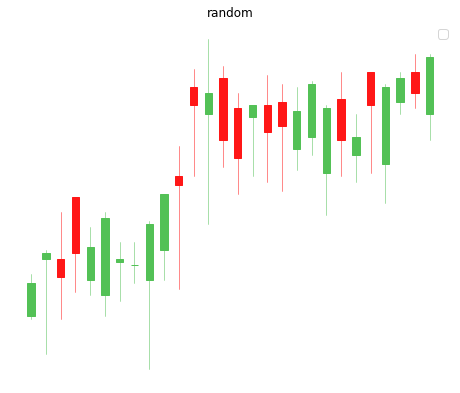

Agregar, Y o N ? or save to create .csv
y


No handles with labels found to put in legend.


Contador: 1
Count: 2/38446


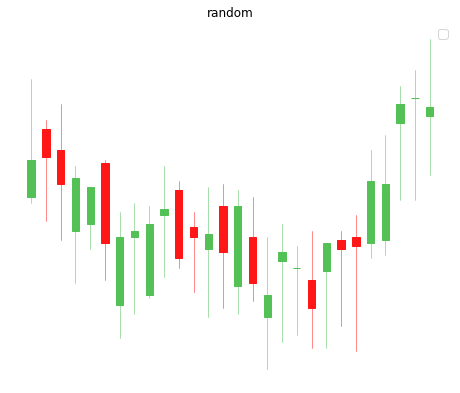

Agregar, Y o N ? or save to create .csv
y


No handles with labels found to put in legend.


Contador: 2
Count: 3/38446


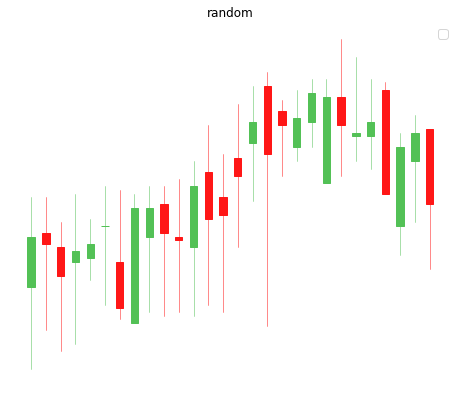

Agregar, Y o N ? or save to create .csv
y


No handles with labels found to put in legend.


Contador: 3
Count: 4/38446


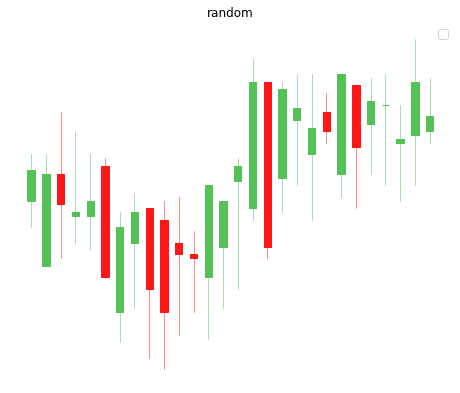

Agregar, Y o N ? or save to create .csv
y


No handles with labels found to put in legend.


Contador: 4
Count: 5/38446


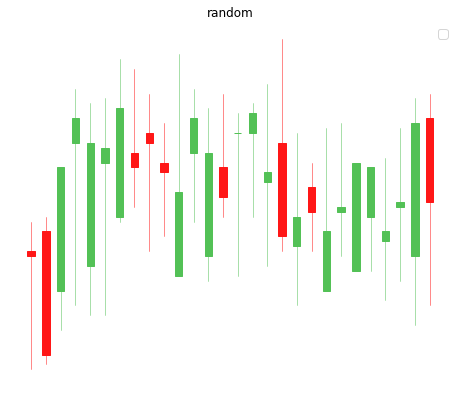

Agregar, Y o N ? or save to create .csv
y


No handles with labels found to put in legend.


Contador: 5
Count: 6/38446


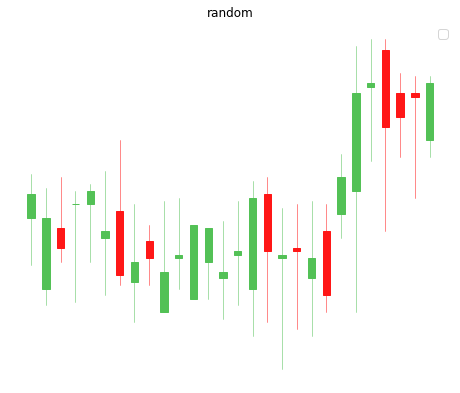

Agregar, Y o N ? or save to create .csv
y


No handles with labels found to put in legend.


Contador: 6
Count: 7/38446


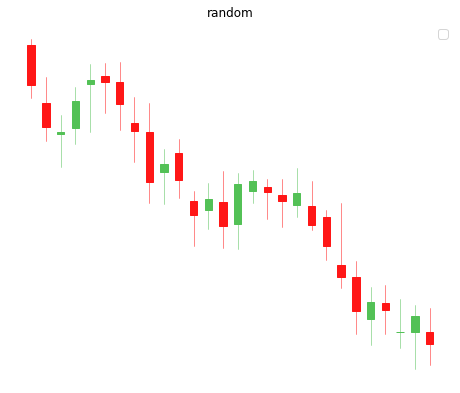

Agregar, Y o N ? or save to create .csv
y


No handles with labels found to put in legend.


Contador: 7
Count: 8/38446


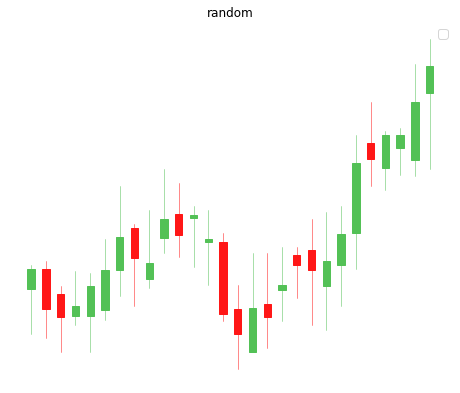

Agregar, Y o N ? or save to create .csv
y


No handles with labels found to put in legend.


Contador: 8
Count: 9/38446


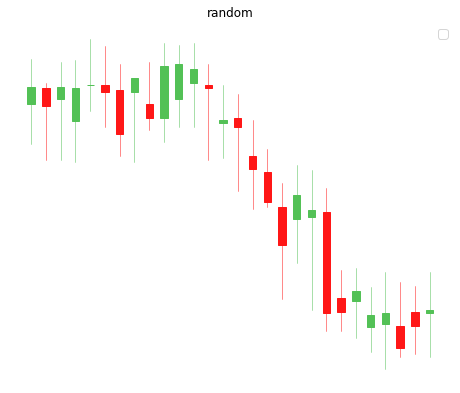

Agregar, Y o N ? or save to create .csv
y
Contador: 9
Count: 10/38446


No handles with labels found to put in legend.


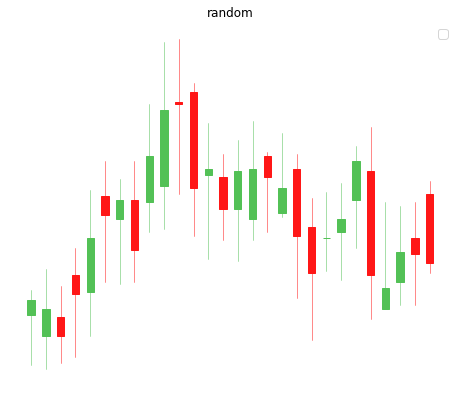

Agregar, Y o N ? or save to create .csv
y


No handles with labels found to put in legend.


Contador: 10
Count: 11/38446


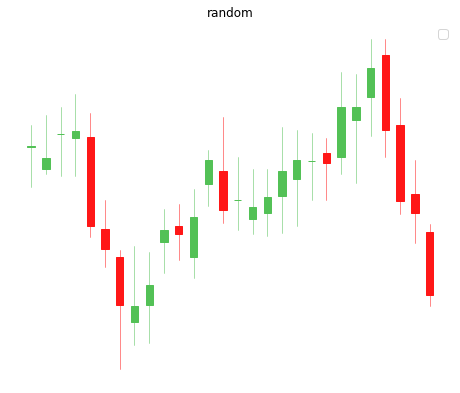

Agregar, Y o N ? or save to create .csv
y


No handles with labels found to put in legend.


Contador: 11
Count: 12/38446


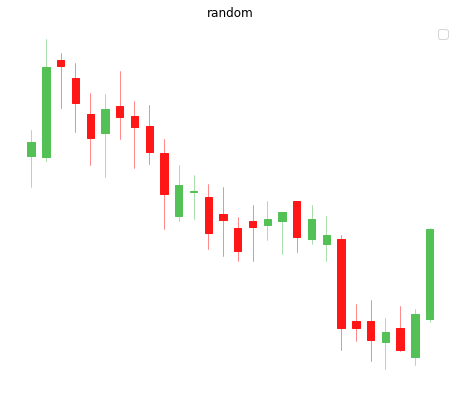

Agregar, Y o N ? or save to create .csv
y


No handles with labels found to put in legend.


Contador: 12
Count: 13/38446


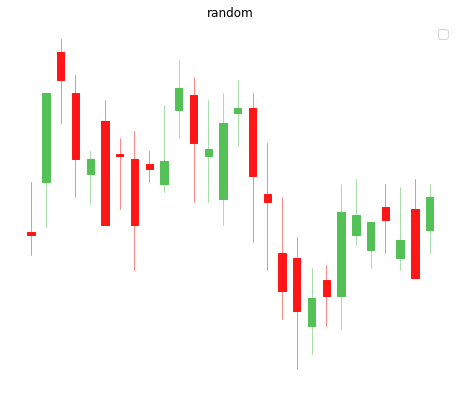

Agregar, Y o N ? or save to create .csv
y


No handles with labels found to put in legend.


Contador: 13
Count: 14/38446


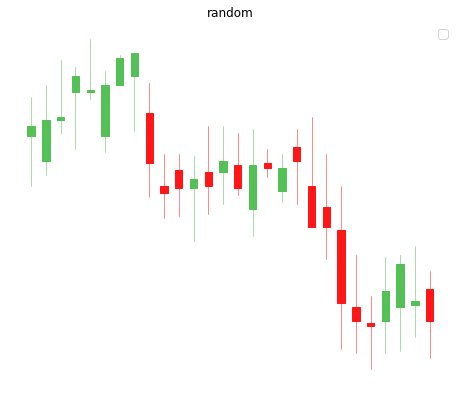

Agregar, Y o N ? or save to create .csv
y


No handles with labels found to put in legend.


Contador: 14
Count: 15/38446


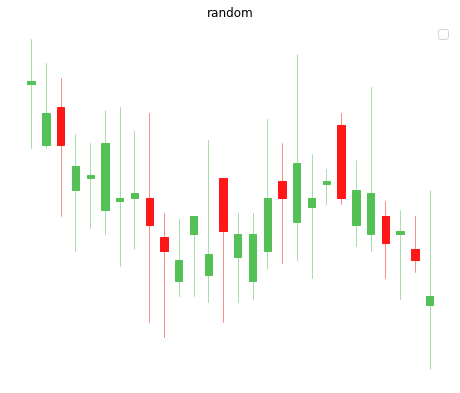

Agregar, Y o N ? or save to create .csv
y


No handles with labels found to put in legend.


Contador: 15
Count: 16/38446


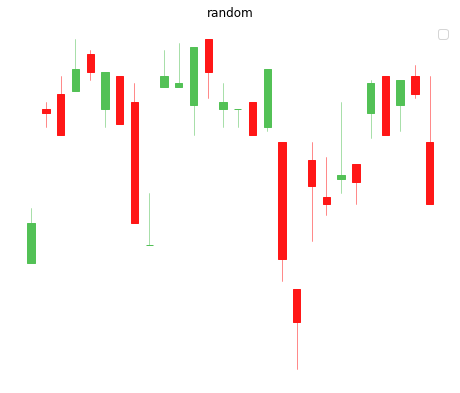

Agregar, Y o N ? or save to create .csv
y


No handles with labels found to put in legend.


Contador: 16
Count: 17/38446


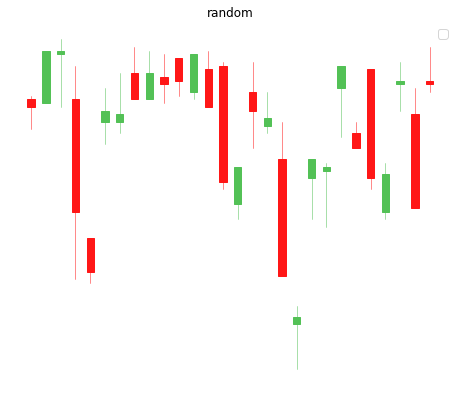

Agregar, Y o N ? or save to create .csv
y


No handles with labels found to put in legend.


Contador: 17
Count: 18/38446


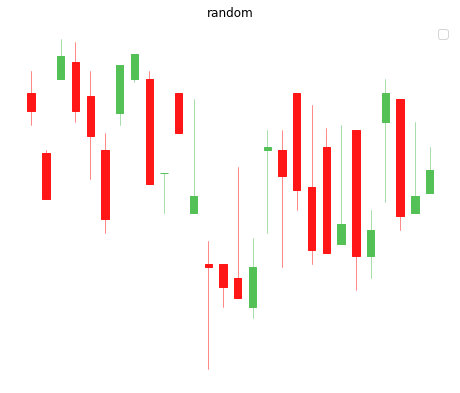

Agregar, Y o N ? or save to create .csv



No handles with labels found to put in legend.


Count: 19/38446


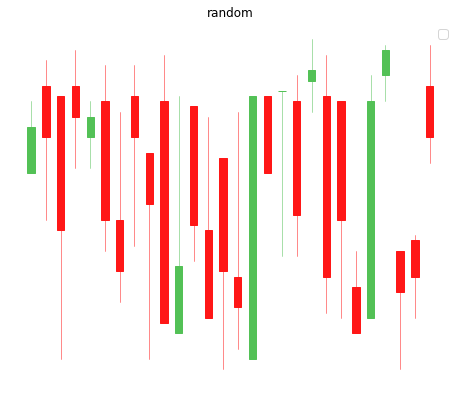

Agregar, Y o N ? or save to create .csv



No handles with labels found to put in legend.


Count: 20/38446


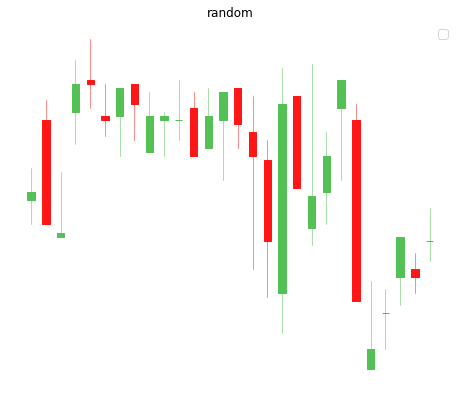

Agregar, Y o N ? or save to create .csv



No handles with labels found to put in legend.


Count: 21/38446


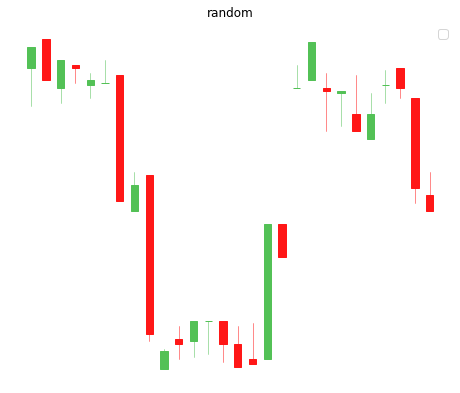

Agregar, Y o N ? or save to create .csv



No handles with labels found to put in legend.


Count: 22/38446


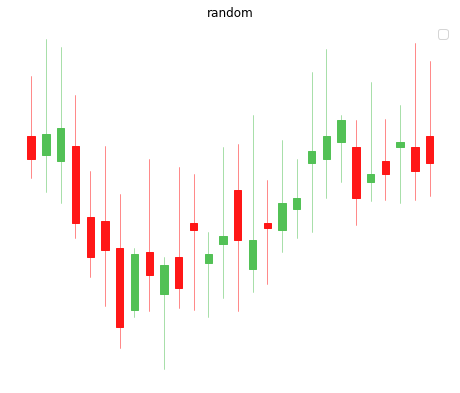

Agregar, Y o N ? or save to create .csv
y


No handles with labels found to put in legend.


Contador: 18
Count: 23/38446


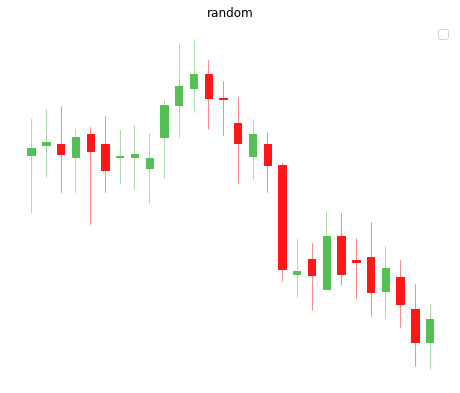

Agregar, Y o N ? or save to create .csv
y


No handles with labels found to put in legend.


Contador: 19
Count: 24/38446


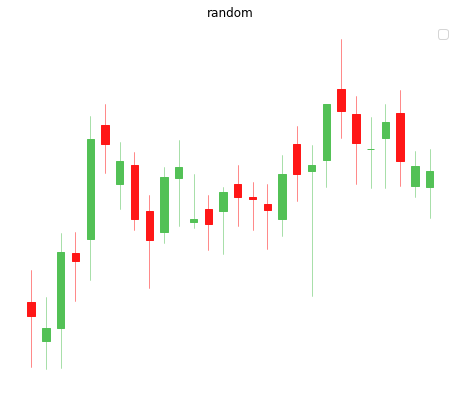

Agregar, Y o N ? or save to create .csv
y


No handles with labels found to put in legend.


Contador: 20
Count: 25/38446


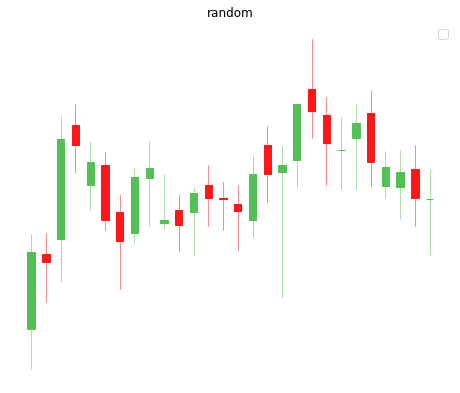

Agregar, Y o N ? or save to create .csv
y


No handles with labels found to put in legend.


Contador: 21
Count: 26/38446


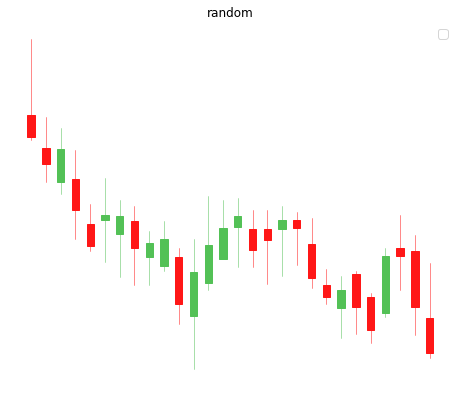

Agregar, Y o N ? or save to create .csv
y


No handles with labels found to put in legend.


Contador: 22
Count: 27/38446


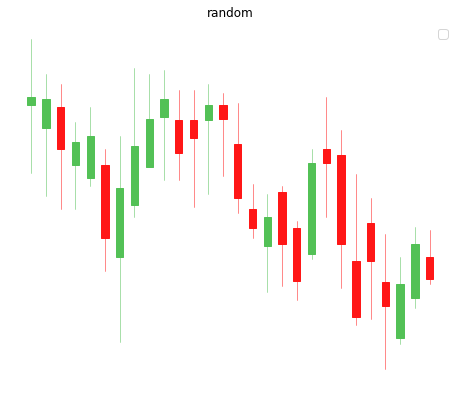

Agregar, Y o N ? or save to create .csv



No handles with labels found to put in legend.


Count: 28/38446


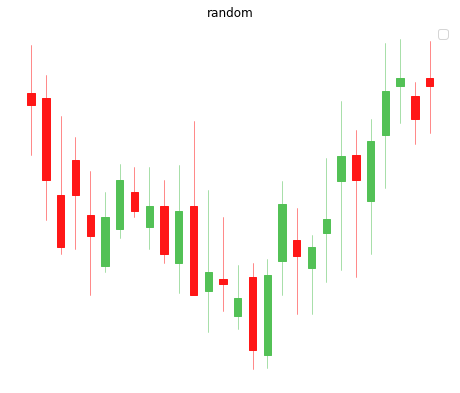

Agregar, Y o N ? or save to create .csv
y


No handles with labels found to put in legend.


Contador: 23
Count: 29/38446


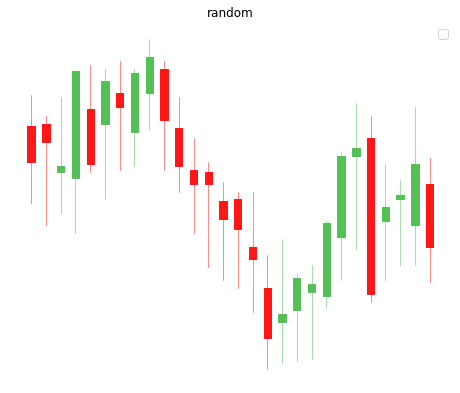

Agregar, Y o N ? or save to create .csv



No handles with labels found to put in legend.


Count: 30/38446


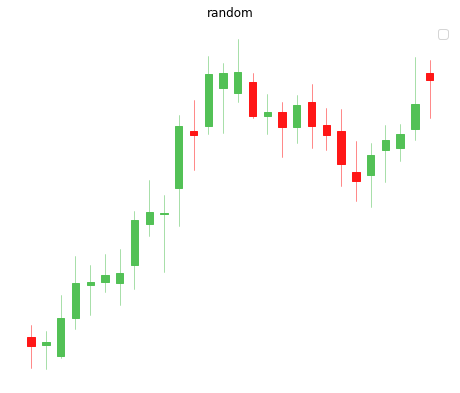

Agregar, Y o N ? or save to create .csv
y


No handles with labels found to put in legend.


Contador: 24
Count: 31/38446


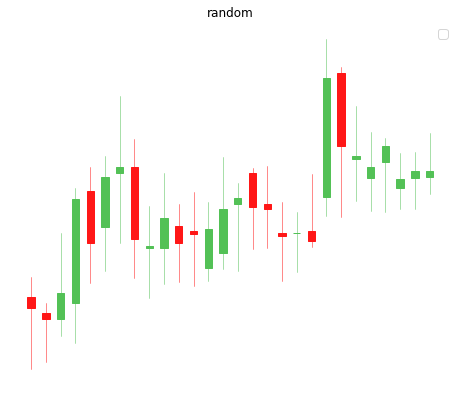

Agregar, Y o N ? or save to create .csv
y


No handles with labels found to put in legend.


Contador: 25
Count: 32/38446


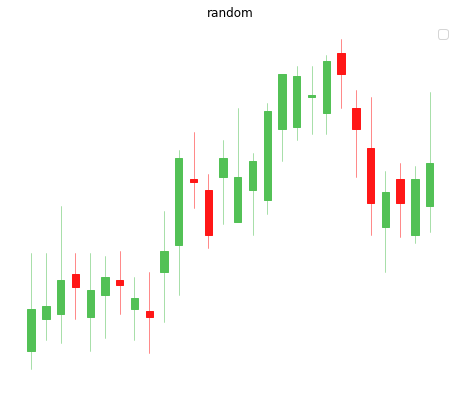

Agregar, Y o N ? or save to create .csv
y


No handles with labels found to put in legend.


Contador: 26
Count: 33/38446


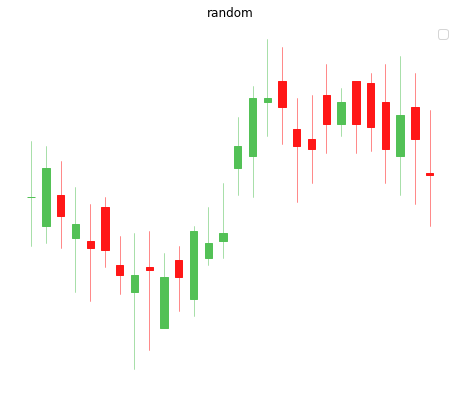

Agregar, Y o N ? or save to create .csv



No handles with labels found to put in legend.


Count: 34/38446


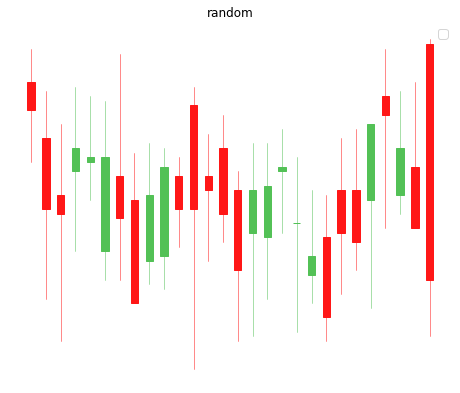

Agregar, Y o N ? or save to create .csv



No handles with labels found to put in legend.


Count: 35/38446


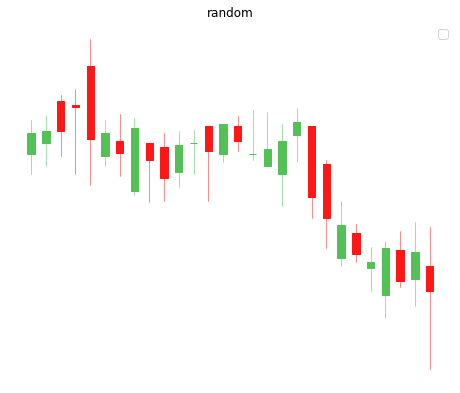

Agregar, Y o N ? or save to create .csv
y


No handles with labels found to put in legend.


Contador: 27
Count: 36/38446


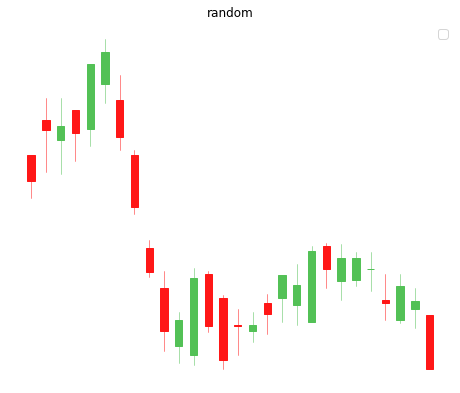

Agregar, Y o N ? or save to create .csv
y


No handles with labels found to put in legend.


Contador: 28
Count: 37/38446


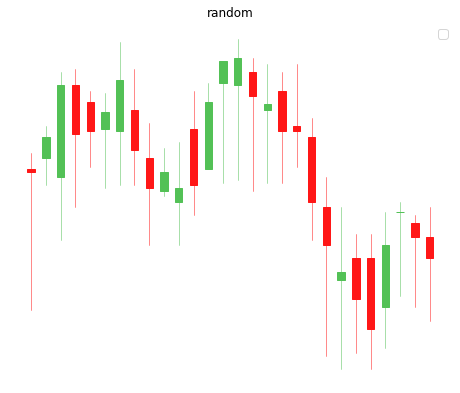

Agregar, Y o N ? or save to create .csv
y


No handles with labels found to put in legend.


Contador: 29
Count: 38/38446


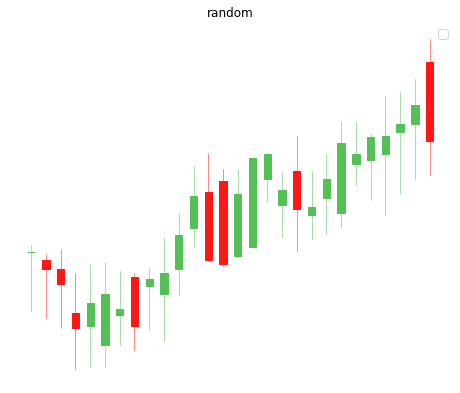

Agregar, Y o N ? or save to create .csv



No handles with labels found to put in legend.


Count: 39/38446


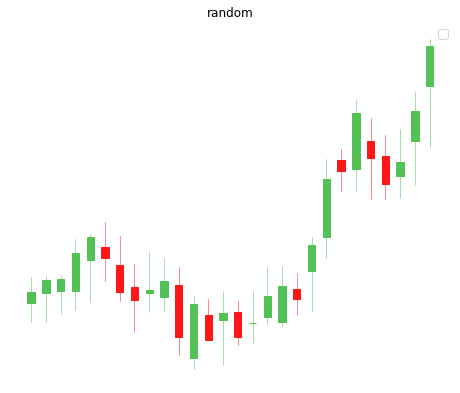

Agregar, Y o N ? or save to create .csv



No handles with labels found to put in legend.


Count: 40/38446


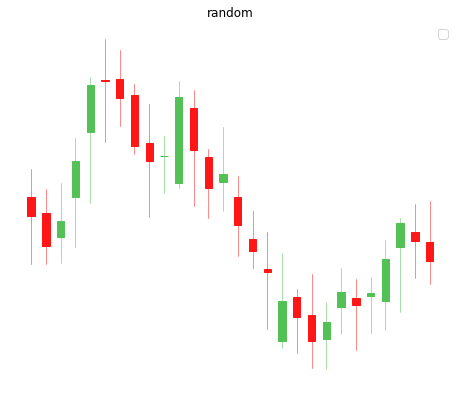

Agregar, Y o N ? or save to create .csv



No handles with labels found to put in legend.


Count: 41/38446


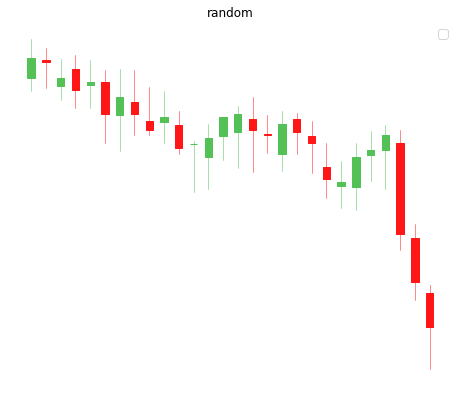

Agregar, Y o N ? or save to create .csv
y


No handles with labels found to put in legend.


Contador: 30
Count: 42/38446


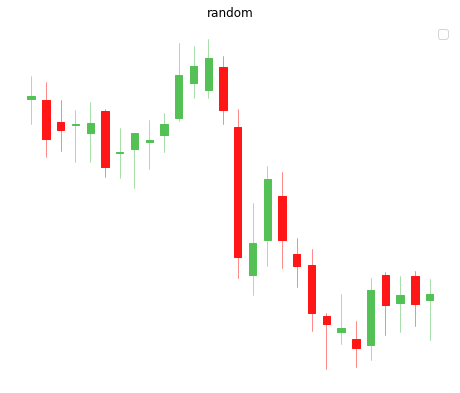

Agregar, Y o N ? or save to create .csv
y


No handles with labels found to put in legend.


Contador: 31
Count: 43/38446


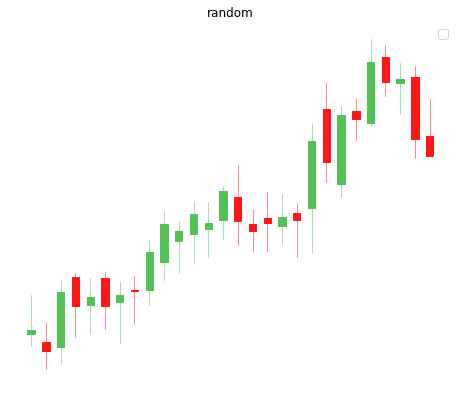

Agregar, Y o N ? or save to create .csv



No handles with labels found to put in legend.


Count: 44/38446


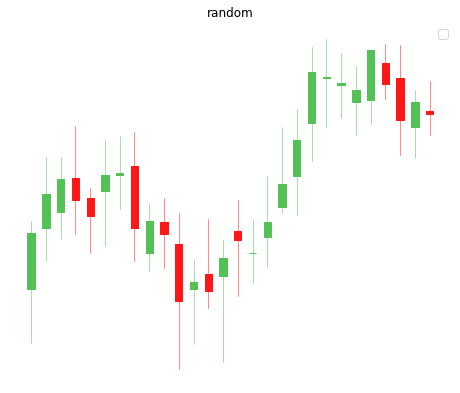

Agregar, Y o N ? or save to create .csv
y


No handles with labels found to put in legend.


Contador: 32
Count: 45/38446


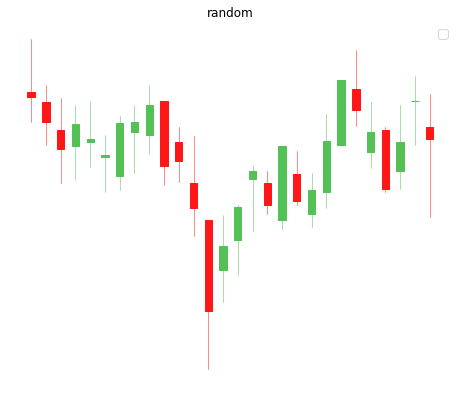

Agregar, Y o N ? or save to create .csv
y


No handles with labels found to put in legend.


Contador: 33
Count: 46/38446


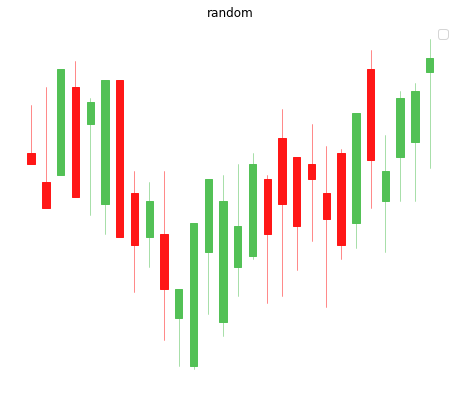

Agregar, Y o N ? or save to create .csv



No handles with labels found to put in legend.


Count: 47/38446


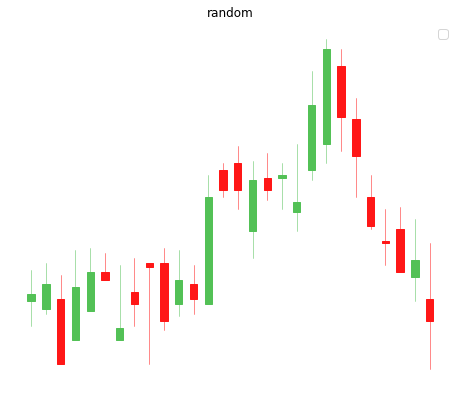

Agregar, Y o N ? or save to create .csv
y


No handles with labels found to put in legend.


Contador: 34
Count: 48/38446


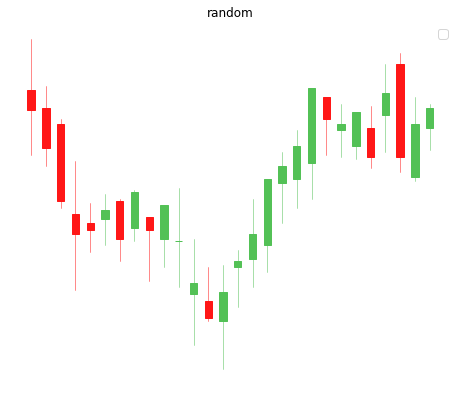

Agregar, Y o N ? or save to create .csv
y


No handles with labels found to put in legend.


Contador: 35
Count: 49/38446


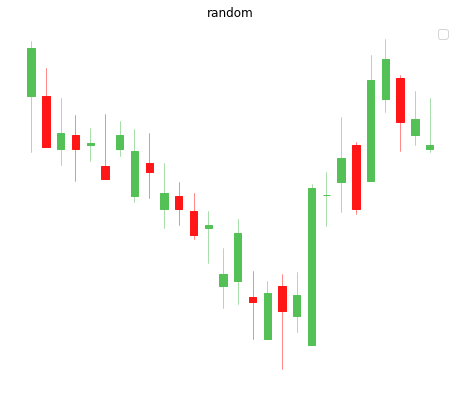

Agregar, Y o N ? or save to create .csv



No handles with labels found to put in legend.


Count: 50/38446


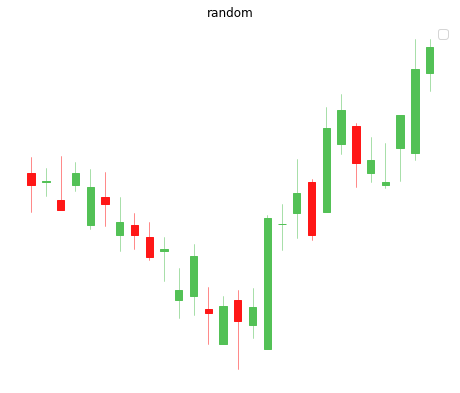

Agregar, Y o N ? or save to create .csv



No handles with labels found to put in legend.


Count: 51/38446


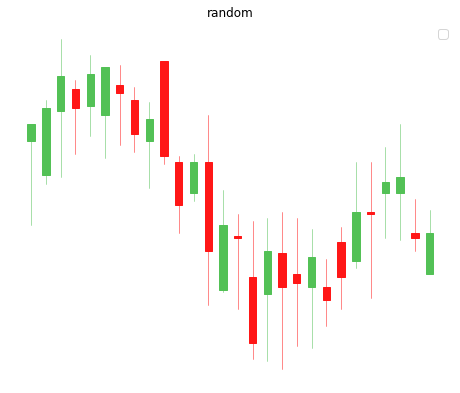

Agregar, Y o N ? or save to create .csv
y


No handles with labels found to put in legend.


Contador: 36
Count: 52/38446


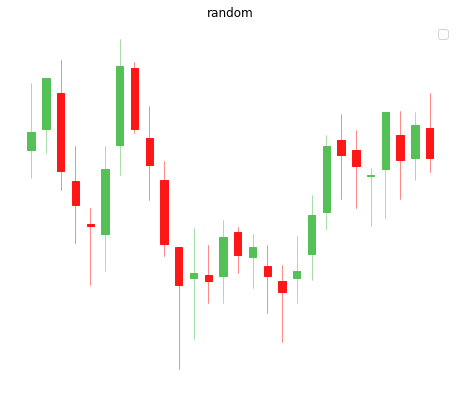

Agregar, Y o N ? or save to create .csv
y


No handles with labels found to put in legend.


Contador: 37
Count: 53/38446


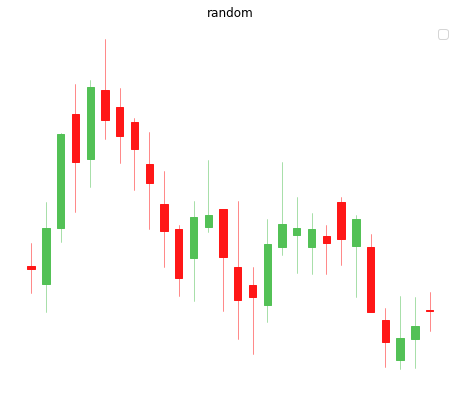

Agregar, Y o N ? or save to create .csv



No handles with labels found to put in legend.


Count: 54/38446


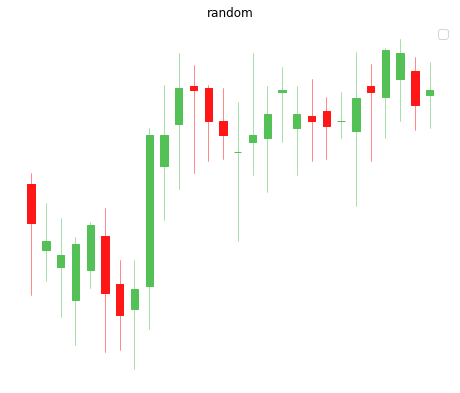

Agregar, Y o N ? or save to create .csv
y


No handles with labels found to put in legend.


Contador: 38
Count: 55/38446


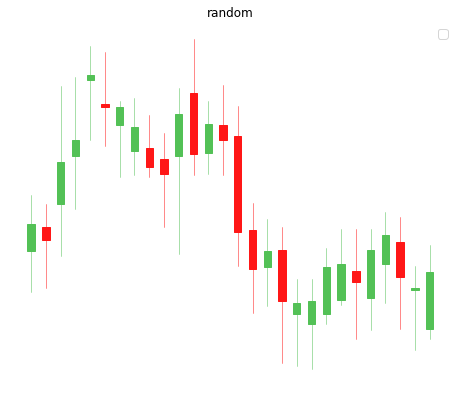

Agregar, Y o N ? or save to create .csv



No handles with labels found to put in legend.


Count: 56/38446


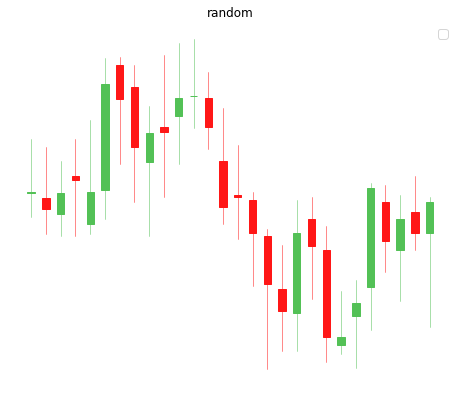

Agregar, Y o N ? or save to create .csv



No handles with labels found to put in legend.


Count: 57/38446


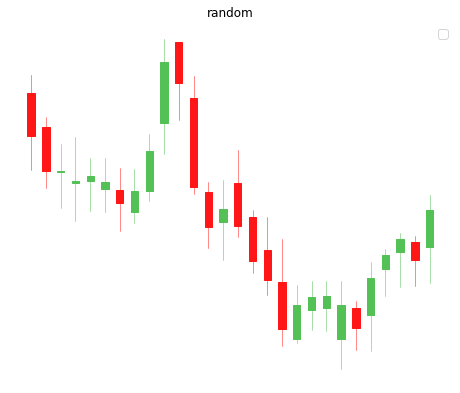

Agregar, Y o N ? or save to create .csv
y


No handles with labels found to put in legend.


Contador: 39
Count: 58/38446


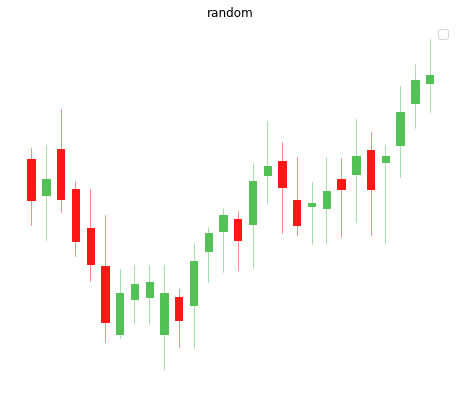

Agregar, Y o N ? or save to create .csv
y


No handles with labels found to put in legend.


Contador: 40
Count: 59/38446


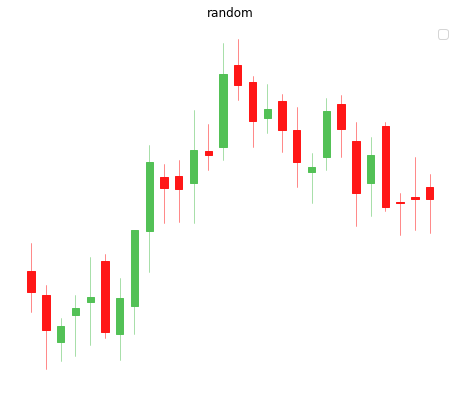

Agregar, Y o N ? or save to create .csv
y


No handles with labels found to put in legend.


Contador: 41
Count: 60/38446


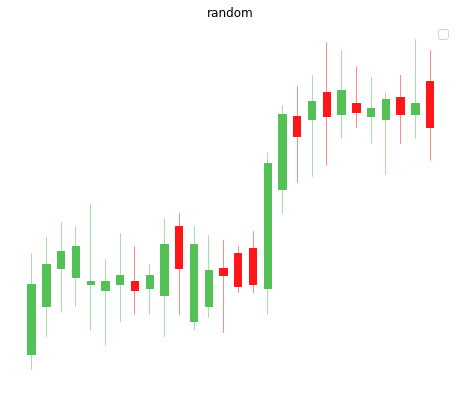

Agregar, Y o N ? or save to create .csv
y


No handles with labels found to put in legend.


Contador: 42
Count: 61/38446


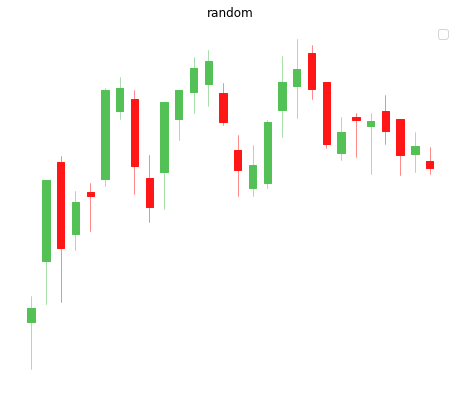

Agregar, Y o N ? or save to create .csv



No handles with labels found to put in legend.


Count: 62/38446


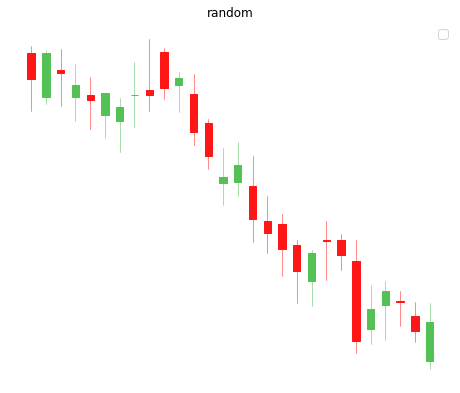

Agregar, Y o N ? or save to create .csv
y


No handles with labels found to put in legend.


Contador: 43
Count: 63/38446


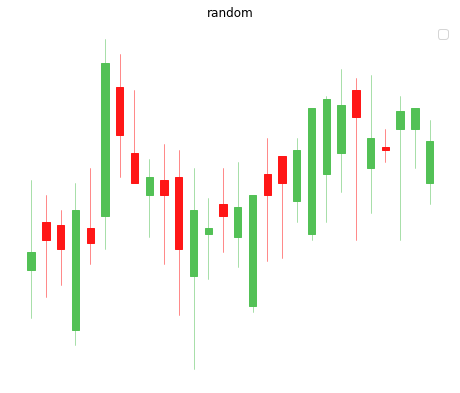

Agregar, Y o N ? or save to create .csv
y


No handles with labels found to put in legend.


Contador: 44
Count: 64/38446


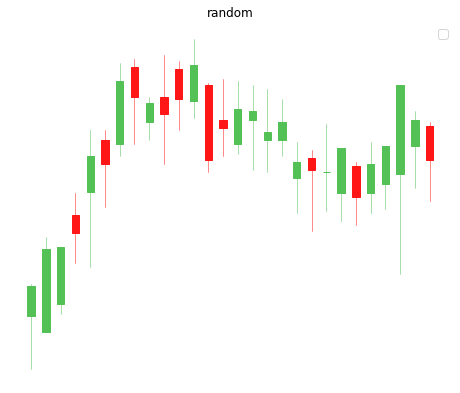

Agregar, Y o N ? or save to create .csv
y


No handles with labels found to put in legend.


Contador: 45
Count: 65/38446


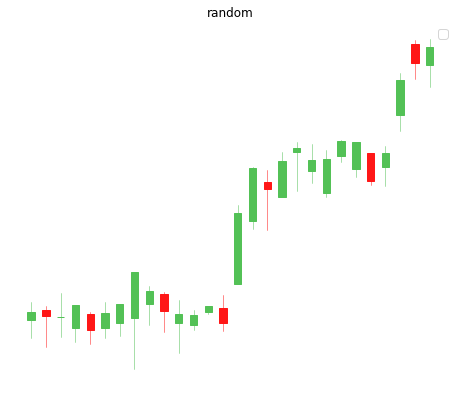

Agregar, Y o N ? or save to create .csv
y


No handles with labels found to put in legend.


Contador: 46
Count: 66/38446


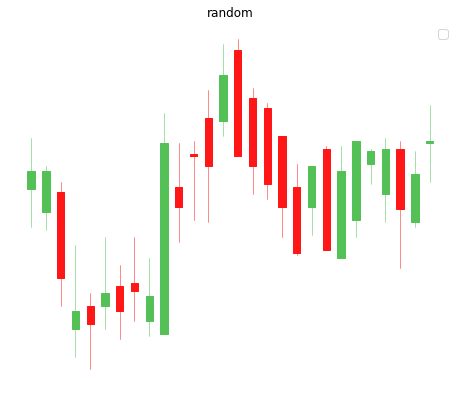

Agregar, Y o N ? or save to create .csv
y


No handles with labels found to put in legend.


Contador: 47
Count: 67/38446


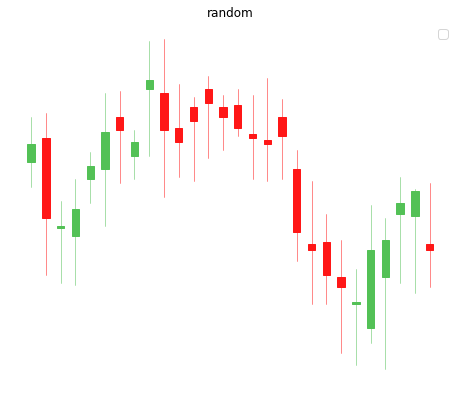

Agregar, Y o N ? or save to create .csv
y


No handles with labels found to put in legend.


Contador: 48
Count: 68/38446


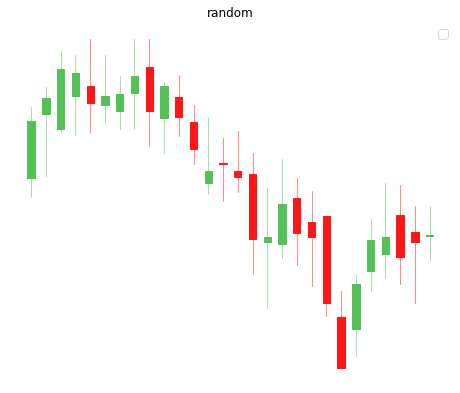

Agregar, Y o N ? or save to create .csv
y


No handles with labels found to put in legend.


Contador: 49
Count: 69/38446


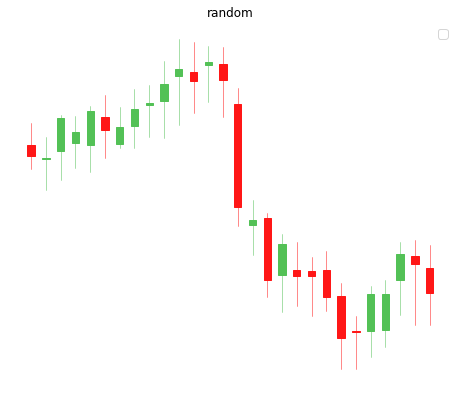

Agregar, Y o N ? or save to create .csv
y


No handles with labels found to put in legend.


Contador: 50
Count: 70/38446


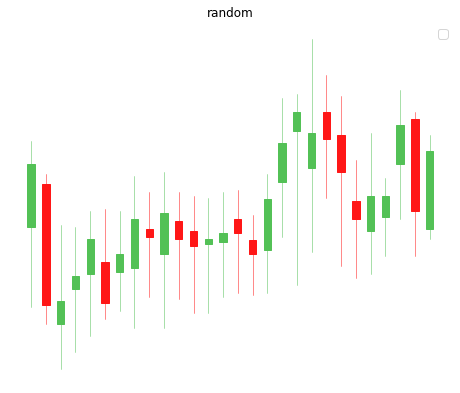

Agregar, Y o N ? or save to create .csv
y


No handles with labels found to put in legend.


Contador: 51
Count: 71/38446


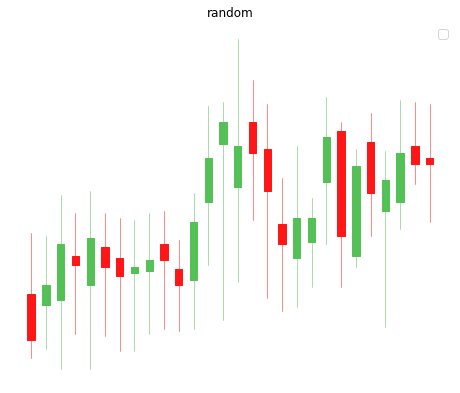

Agregar, Y o N ? or save to create .csv
y


No handles with labels found to put in legend.


Contador: 52
Count: 72/38446


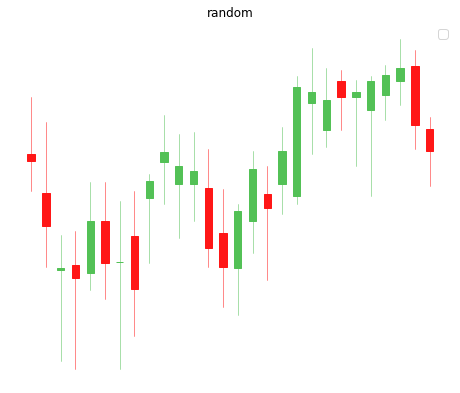

Agregar, Y o N ? or save to create .csv
y


No handles with labels found to put in legend.


Contador: 53
Count: 73/38446


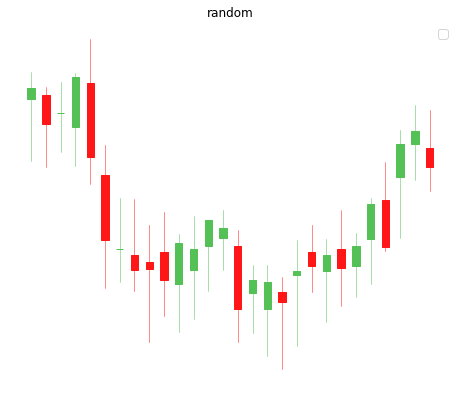

Agregar, Y o N ? or save to create .csv
y


No handles with labels found to put in legend.


Contador: 54
Count: 74/38446


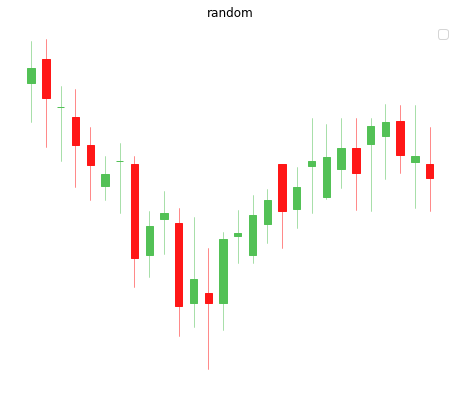

Agregar, Y o N ? or save to create .csv
y


No handles with labels found to put in legend.


Contador: 55
Count: 75/38446


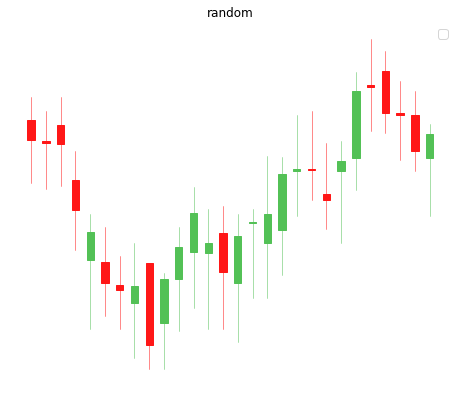

Agregar, Y o N ? or save to create .csv
y


No handles with labels found to put in legend.


Contador: 56
Count: 76/38446


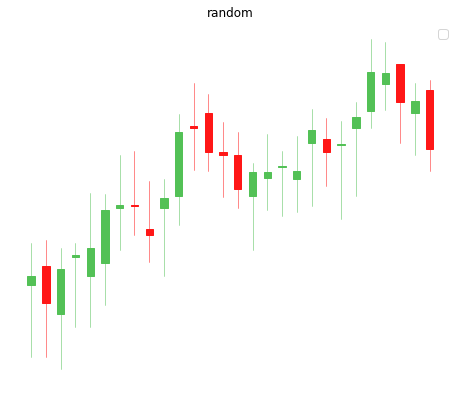

Agregar, Y o N ? or save to create .csv
y


No handles with labels found to put in legend.


Contador: 57
Count: 77/38446


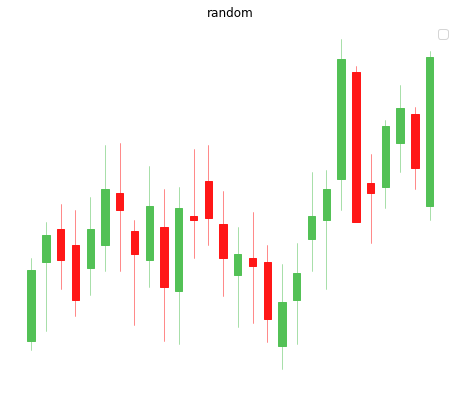

Agregar, Y o N ? or save to create .csv
y


No handles with labels found to put in legend.


Contador: 58
Count: 78/38446


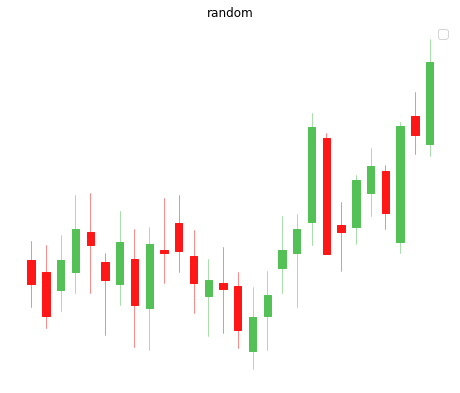

Agregar, Y o N ? or save to create .csv
y


No handles with labels found to put in legend.


Contador: 59
Count: 79/38446


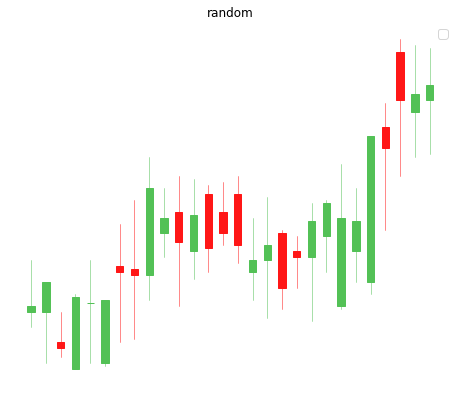

Agregar, Y o N ? or save to create .csv



No handles with labels found to put in legend.


Count: 80/38446


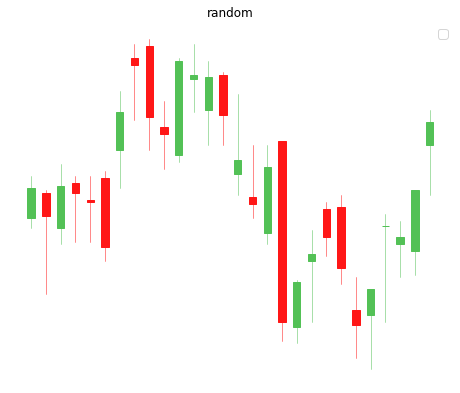

Agregar, Y o N ? or save to create .csv



No handles with labels found to put in legend.


Count: 81/38446


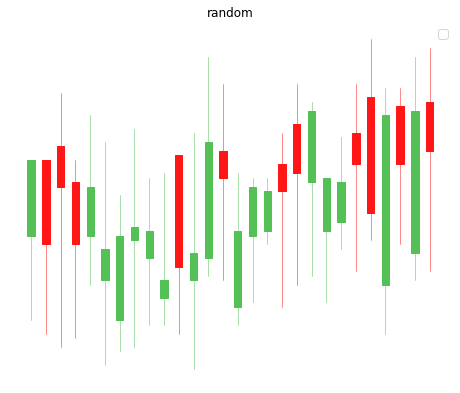

Agregar, Y o N ? or save to create .csv



No handles with labels found to put in legend.


Count: 82/38446


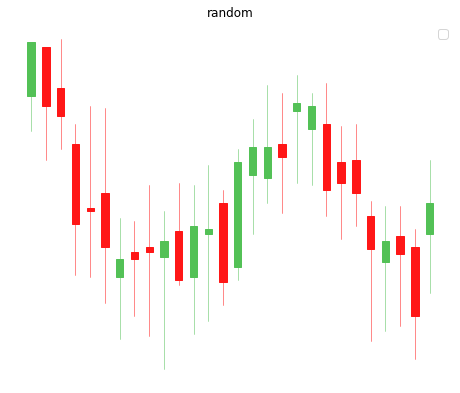

Agregar, Y o N ? or save to create .csv
y


No handles with labels found to put in legend.


Contador: 60
Count: 83/38446


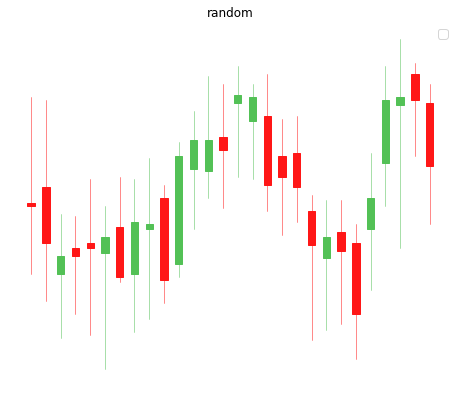

Agregar, Y o N ? or save to create .csv
y


No handles with labels found to put in legend.


Contador: 61
Count: 84/38446


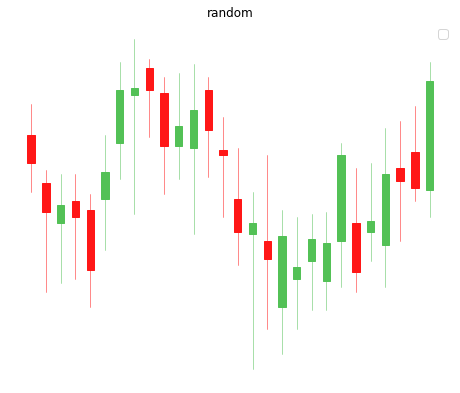

Agregar, Y o N ? or save to create .csv



No handles with labels found to put in legend.


Count: 85/38446


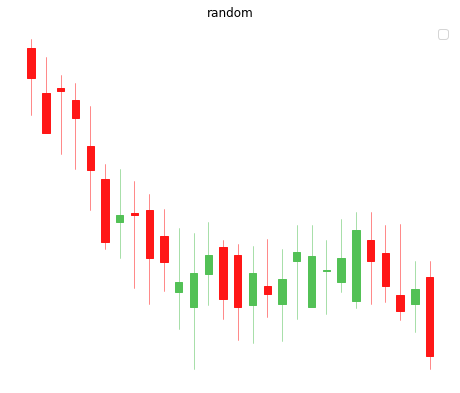

Agregar, Y o N ? or save to create .csv



No handles with labels found to put in legend.


Count: 86/38446


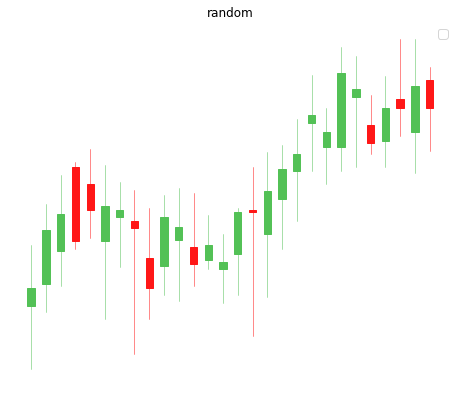

Agregar, Y o N ? or save to create .csv
y


No handles with labels found to put in legend.


Contador: 62
Count: 87/38446


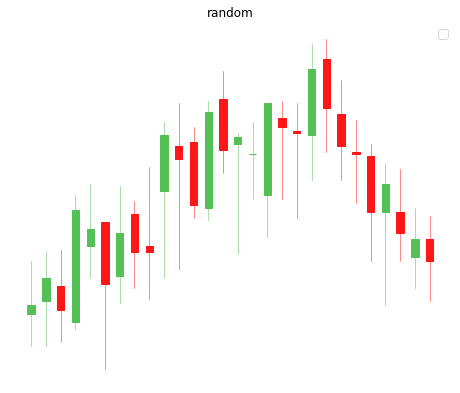

Agregar, Y o N ? or save to create .csv
y


No handles with labels found to put in legend.


Contador: 63
Count: 88/38446


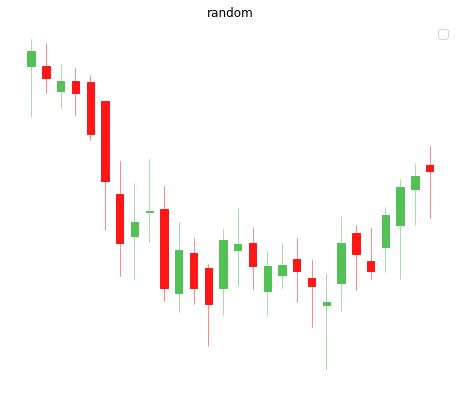

Agregar, Y o N ? or save to create .csv



No handles with labels found to put in legend.


Count: 89/38446


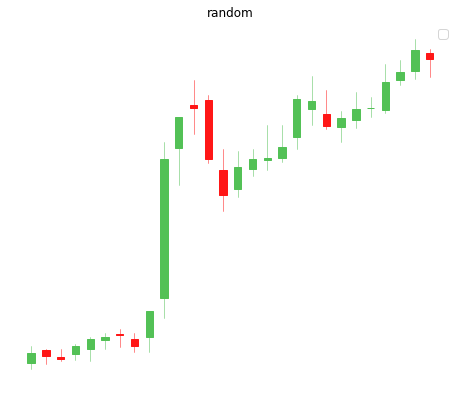

Agregar, Y o N ? or save to create .csv
y


No handles with labels found to put in legend.


Contador: 64
Count: 90/38446


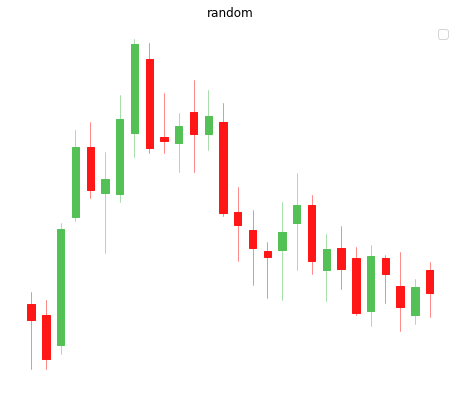

Agregar, Y o N ? or save to create .csv
y


No handles with labels found to put in legend.


Contador: 65
Count: 91/38446


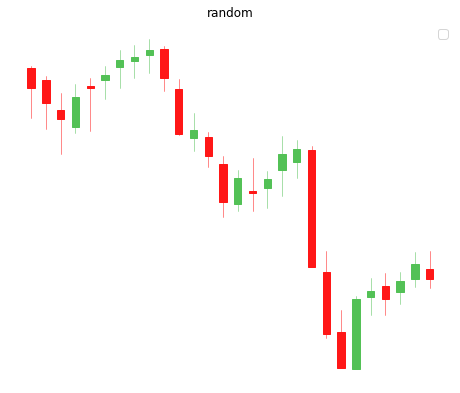

Agregar, Y o N ? or save to create .csv
y


No handles with labels found to put in legend.


Contador: 66
Count: 92/38446


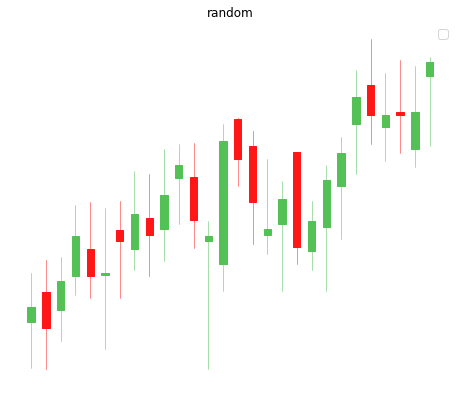

Agregar, Y o N ? or save to create .csv
y


No handles with labels found to put in legend.


Contador: 67
Count: 93/38446


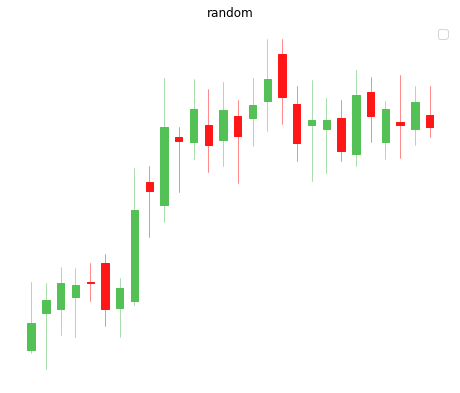

Agregar, Y o N ? or save to create .csv
y


No handles with labels found to put in legend.


Contador: 68
Count: 94/38446


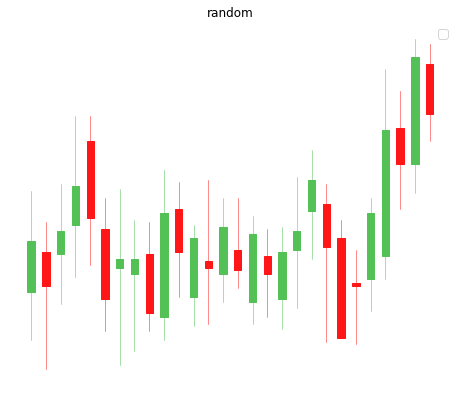

Agregar, Y o N ? or save to create .csv
y


No handles with labels found to put in legend.


Contador: 69
Count: 95/38446


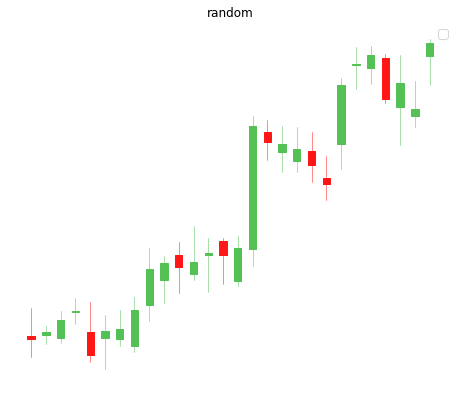

Agregar, Y o N ? or save to create .csv
y


No handles with labels found to put in legend.


Contador: 70
Count: 96/38446


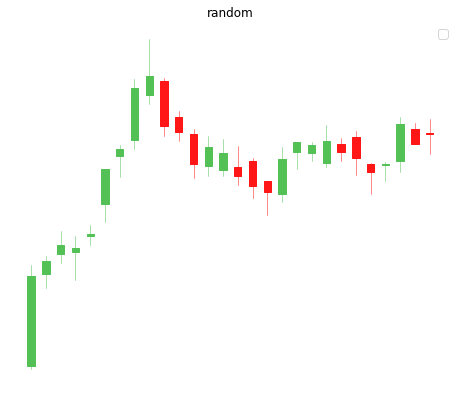

Agregar, Y o N ? or save to create .csv
y


No handles with labels found to put in legend.


Contador: 71
Count: 97/38446


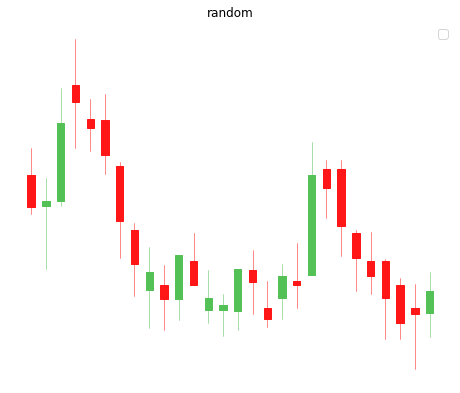

Agregar, Y o N ? or save to create .csv
y


No handles with labels found to put in legend.


Contador: 72
Count: 98/38446


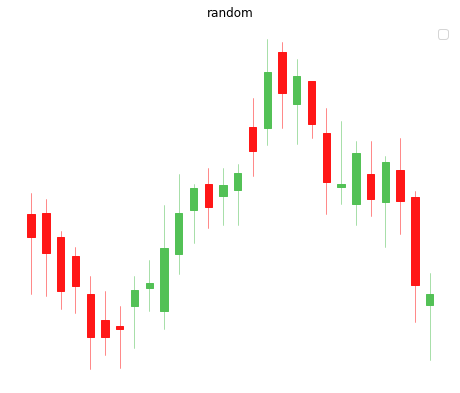

Agregar, Y o N ? or save to create .csv



No handles with labels found to put in legend.


Count: 99/38446


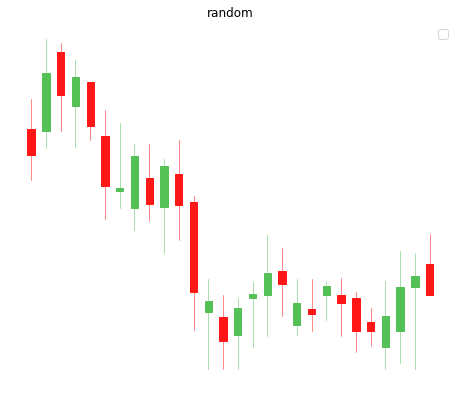

Agregar, Y o N ? or save to create .csv
y


No handles with labels found to put in legend.


Contador: 73
Count: 100/38446


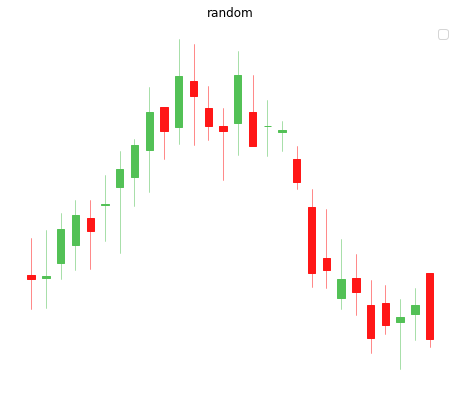

Agregar, Y o N ? or save to create .csv



No handles with labels found to put in legend.


Count: 101/38446


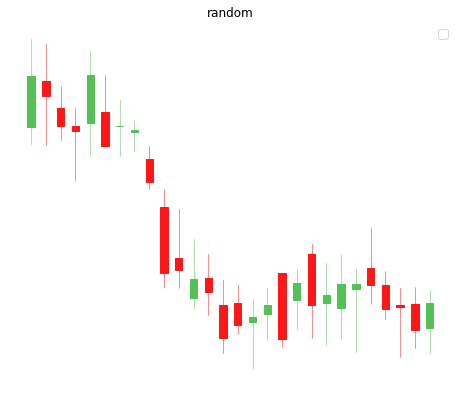

Agregar, Y o N ? or save to create .csv
y


No handles with labels found to put in legend.


Contador: 74
Count: 102/38446


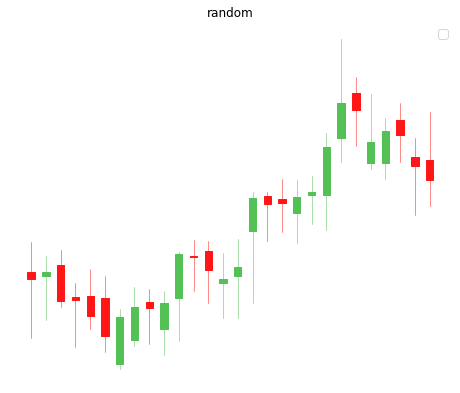

Agregar, Y o N ? or save to create .csv
y


No handles with labels found to put in legend.


Contador: 75
Count: 103/38446


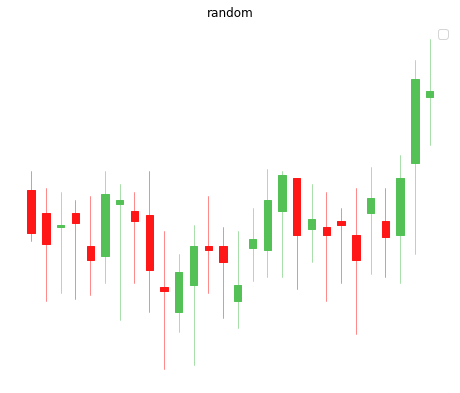

Agregar, Y o N ? or save to create .csv
y


No handles with labels found to put in legend.


Contador: 76
Count: 104/38446


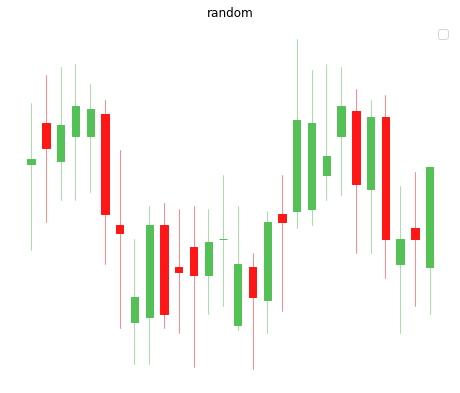

Agregar, Y o N ? or save to create .csv
y


No handles with labels found to put in legend.


Contador: 77
Count: 105/38446


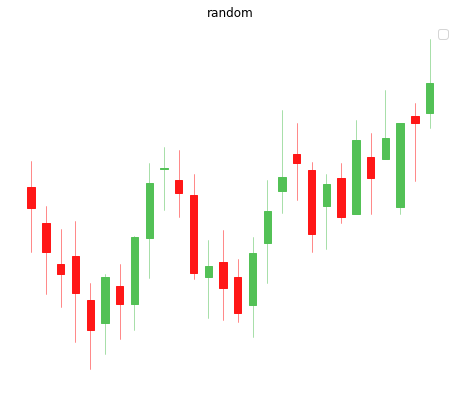

Agregar, Y o N ? or save to create .csv
y


No handles with labels found to put in legend.


Contador: 78
Count: 106/38446


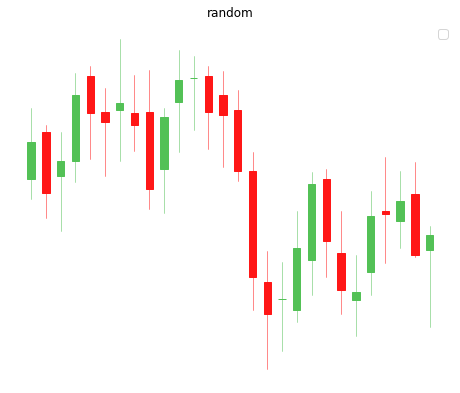

Agregar, Y o N ? or save to create .csv



No handles with labels found to put in legend.


Count: 107/38446


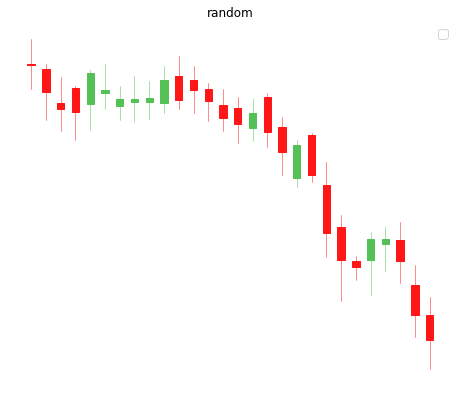

Agregar, Y o N ? or save to create .csv



No handles with labels found to put in legend.


Count: 108/38446


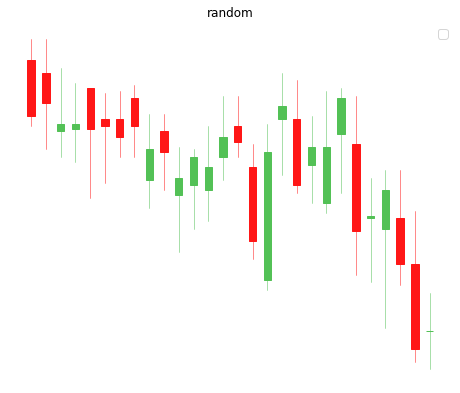

Agregar, Y o N ? or save to create .csv



No handles with labels found to put in legend.


Count: 109/38446


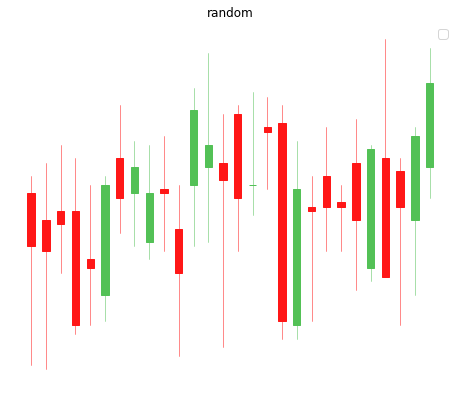

Agregar, Y o N ? or save to create .csv



No handles with labels found to put in legend.


Count: 110/38446


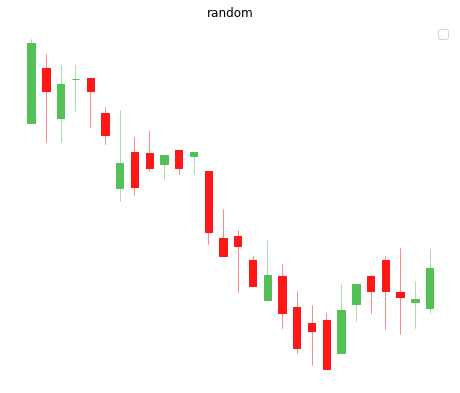

Agregar, Y o N ? or save to create .csv



No handles with labels found to put in legend.


Count: 111/38446


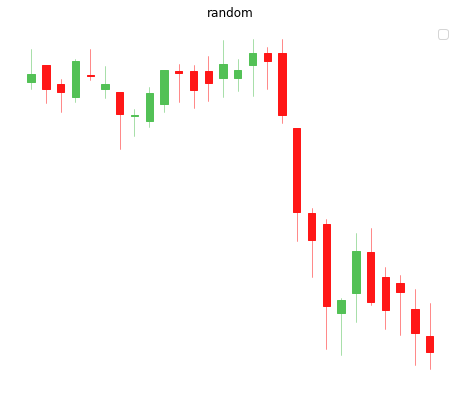

Agregar, Y o N ? or save to create .csv
y


No handles with labels found to put in legend.


Contador: 79
Count: 112/38446


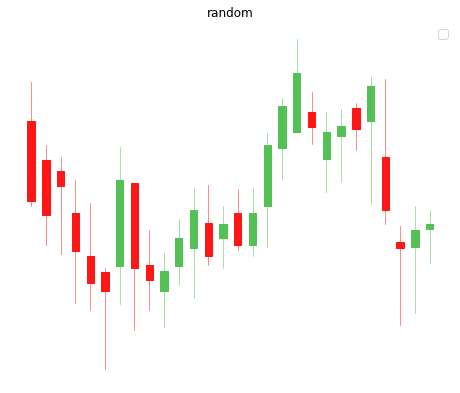

Agregar, Y o N ? or save to create .csv



No handles with labels found to put in legend.


Count: 113/38446


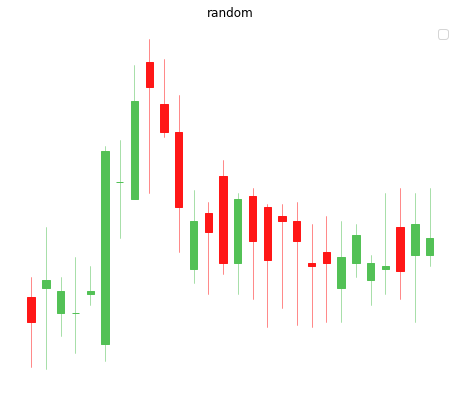

Agregar, Y o N ? or save to create .csv
y


No handles with labels found to put in legend.


Contador: 80
Count: 114/38446


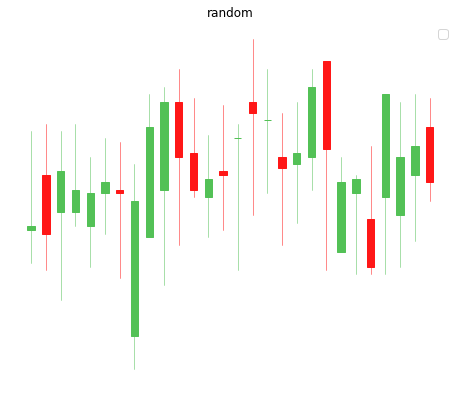

Agregar, Y o N ? or save to create .csv
save


No handles with labels found to put in legend.


patrones_random_80_EURUSD.csv
Count: 115/38446


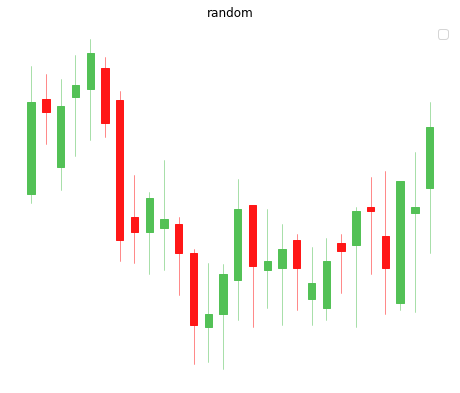

Agregar, Y o N ? or save to create .csv


KeyboardInterrupt: ignored

In [ ]:
# Open file of one of the markets to be analyzed
df = pd.read_csv('/content/drive/MyDrive/Tesis de grado/datos/Datos sin procesar/QuantDataManager/EURUSD_M1_UTCMinus03-M1.csv', 
                 header=0, names=["date","time","open","max","min","close","volumen"])

# Name of the market
currency = 'EURUSD'

# Add "body" field, being the difference between the closing and opening of the Japanese candlesticks.
df['body'] = np.where(df['close'] >= df['open'],
                               abs(df.close - df.open)/2 + df.open,
                               abs(df.close - df.open)/2 + df.close)

# Take the set of candles that appear in the imported dataset
df_copy = df.iloc[0:3900000].copy() 

# Size of the window in which the pattern is observed 
window_size = 28 
set_values_dt(window_size)  
set_values_sh(window_size) 

# Name of pattern to be labeled
patternTag = 'double_top'

# Look for the possible occurrence of the previously defined pattern based on market movements
df_copy[patternTag] = df_copy['body'].rolling(window_size).apply(double_top)

# Print the number of possible patterns detected
allPatternCount = df_copy[patropatternTagnTag].value_counts()
print(str(allPatternCount))
print("Continue...")
resp = input()


# Run through the detected patterns, one by one, to visually check if they add up to the labeled dataset
new_df = df_copy.loc[df_copy[patternTag] == True]
df_marks = pd.DataFrame()
counter = 0
aux = 1
for index in new_df.index:

  print('Count: '+str(aux)+'/'+str(allPatternCount[1]))

  # Visualize the image of the found pattern
  pattern_show_image(patternTag, df_copy.loc[index-(window_size-1):index,'open':'close'])
  aux += 1

  # Ask for confirmation to add it to a tagged data set
  print("Add, Y o N ? or save to create .csv")
  resp = input()
  if resp == 'y' or resp == 'Y':
    df_marks = df_marks.append(df_copy.loc[index-(window_size-1):index,'open':'close'], ignore_index=True)
    counter += 1
    print('Counter: ' + str(counter) )
  if resp == 'save':
    # Save file .csv
    df_marks.to_csv('patterns_'+str(patternTag)+'_'+str(counter)+'_'+str(counter)+ '_' + str(currency)+'.csv', index=False)   
    print('pattens_'+str(patternTag)+'_'+str(counter)+ '_' + str(currency)+'.csv')
  
